In [1]:
# Dependencies

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt
%matplotlib inline

font = {'size'   : 14}

plt.rc('font', **font)

In [2]:
# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split  # not used here, split based on provider
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# for integer encoding using sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve  


from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

from sklearn.metrics import auc,plot_precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

from sklearn.metrics import roc_curve,auc,RocCurveDisplay

from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay


import xgboost as xgb
from sklearn.svm import SVC

# Set seed for reproducibility
seed1, seed2, seed3=101,67, 42

## Load and Merge Data

In [3]:
# load the data from csv to pandas dataframe
X_test_aggregated_raw = pd.read_csv("output/agg_train_test_split/X_test_0817.csv")
X_train_aggregated_raw = pd.read_csv("output/agg_train_test_split/X_train_0817.csv")
y_test_aggregated_raw = pd.read_csv("output/agg_train_test_split/y_test_0817.csv")
y_train_aggregated_raw = pd.read_csv("output/agg_train_test_split/y_train_0817.csv")

In [4]:
y_train_aggregated_raw.describe(),y_test_aggregated_raw.describe()

(       PotentialFraud
 count     4328.000000
 mean         0.093115
 std          0.290627
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max          1.000000,
        PotentialFraud
 count     1082.000000
 mean         0.095194
 std          0.293619
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max          1.000000)

In [5]:
X_train_aggregated_raw.info(),X_test_aggregated_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4328 entries, 0 to 4327
Columns: 105 entries, Provider to TotalTeProcCode
dtypes: float64(43), int64(61), object(1)
memory usage: 3.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Columns: 105 entries, Provider to TotalTeProcCode
dtypes: float64(43), int64(61), object(1)
memory usage: 887.7+ KB


(None, None)

## Basic Transformation

In [6]:
y_train=y_train_aggregated_raw['PotentialFraud']
y_test=y_test_aggregated_raw['PotentialFraud']

X_train=X_train_aggregated_raw.drop('Provider',axis=1).fillna(0)
X_test=X_test_aggregated_raw.drop('Provider',axis=1).fillna(0)

In [7]:
xgb_cl = xgb.XGBClassifier()

classification_models={
    'LogisticRegression':LogisticRegression(class_weight ='balanced',C=0.01,random_state=seed2, max_iter=10000),
    'RandomForest':RandomForestClassifier(n_estimators=20, class_weight='balanced', random_state = seed2),
    'XGBClassifier':xgb.XGBClassifier(n_estimators=3, random_state = seed2),
    'SVC':SVC(kernel='rbf',C=0.1,class_weight ='balanced',probability=True,random_state=seed2),
}



## Logistic Regression


>>>>>>>>>>>>>>>>>>>>>>>>>> LogisticRegression model results <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


average precision of cross-validation:0.785


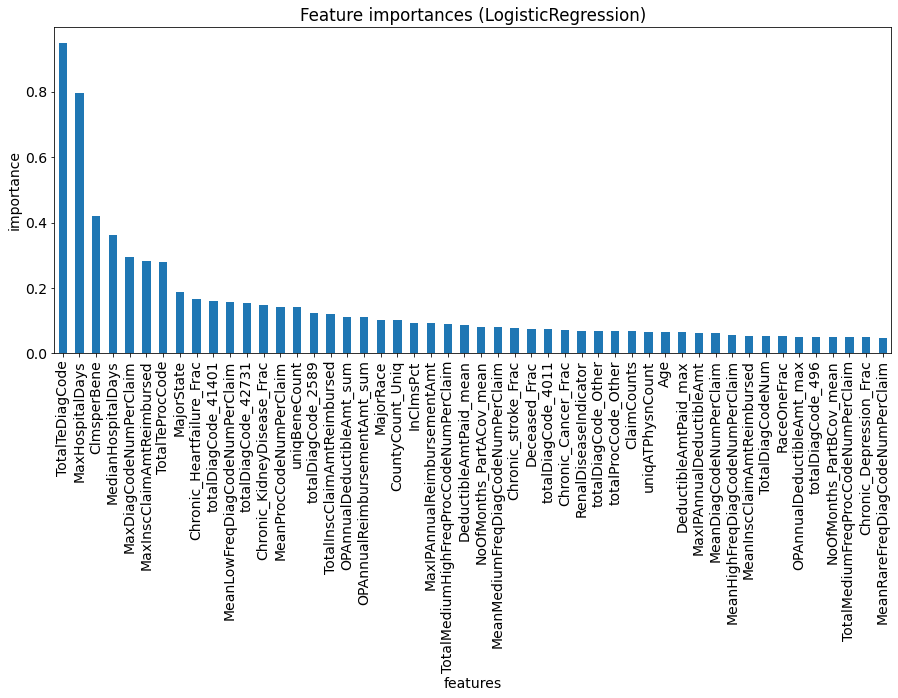

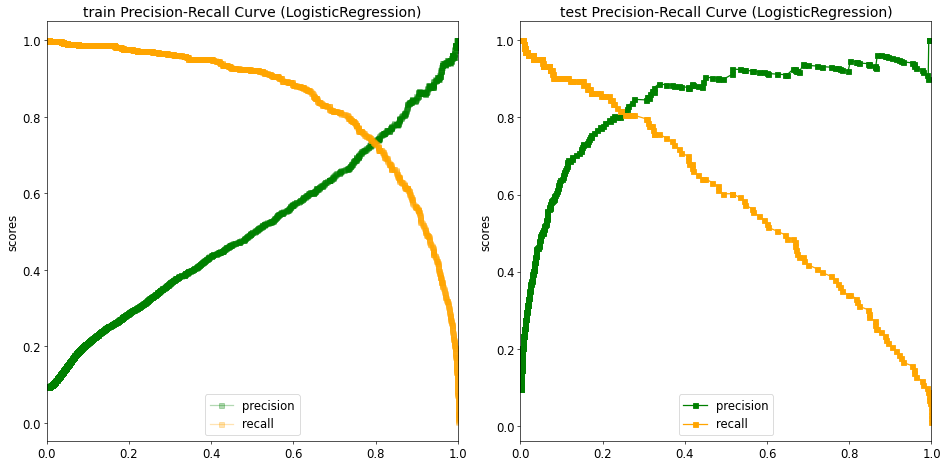


>>>>>>>>>>>>>>>>>>>>>>>>>> RandomForest model results <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


average precision of cross-validation:0.826


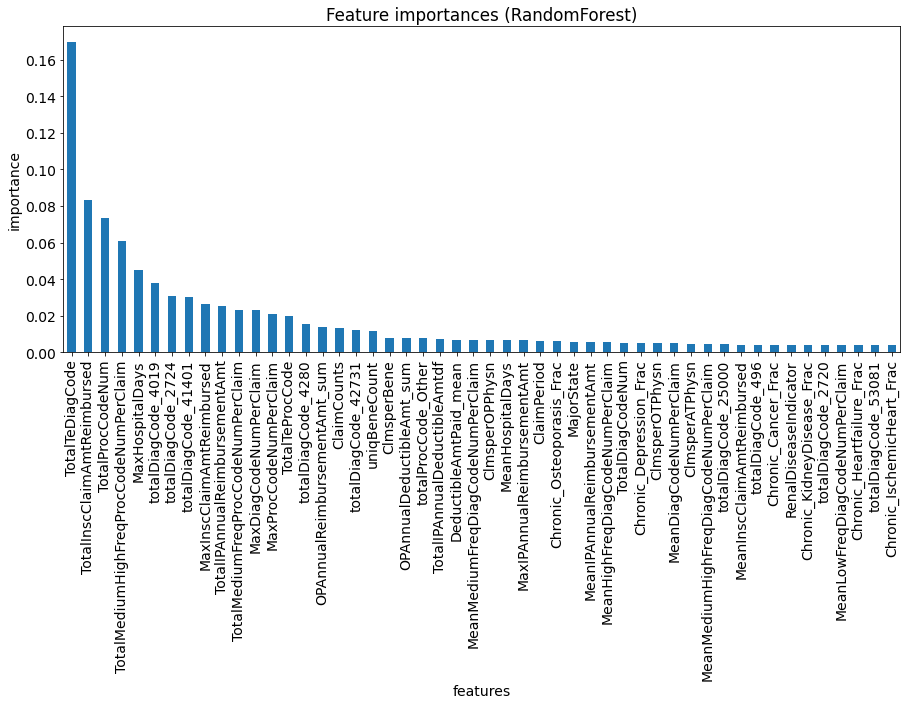

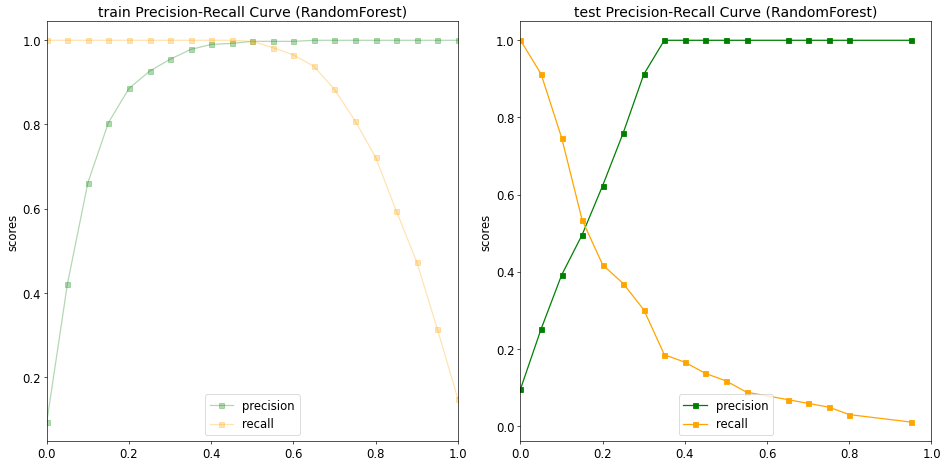


>>>>>>>>>>>>>>>>>>>>>>>>>> XGBClassifier model results <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


average precision of cross-validation:0.856


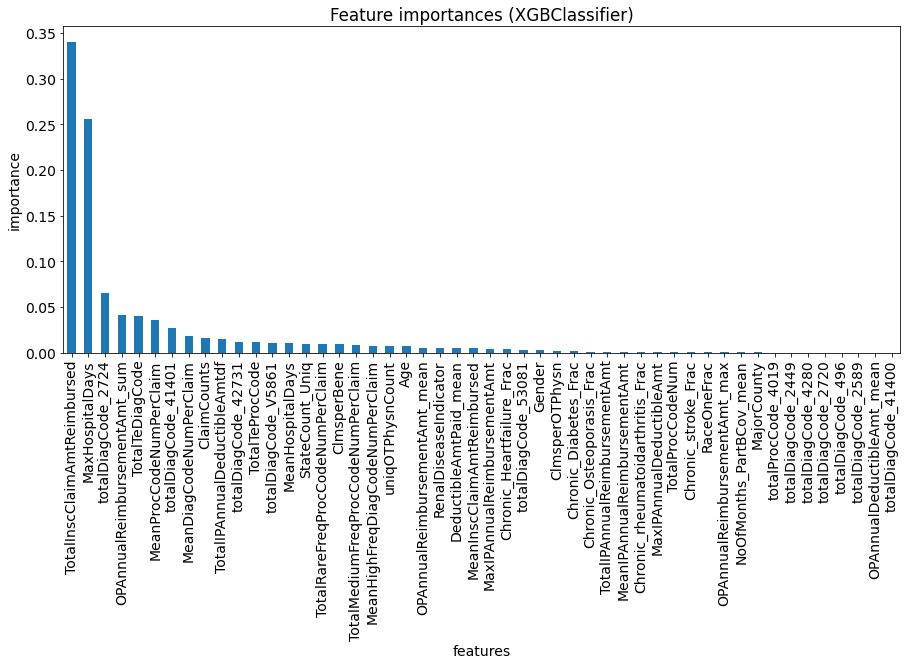

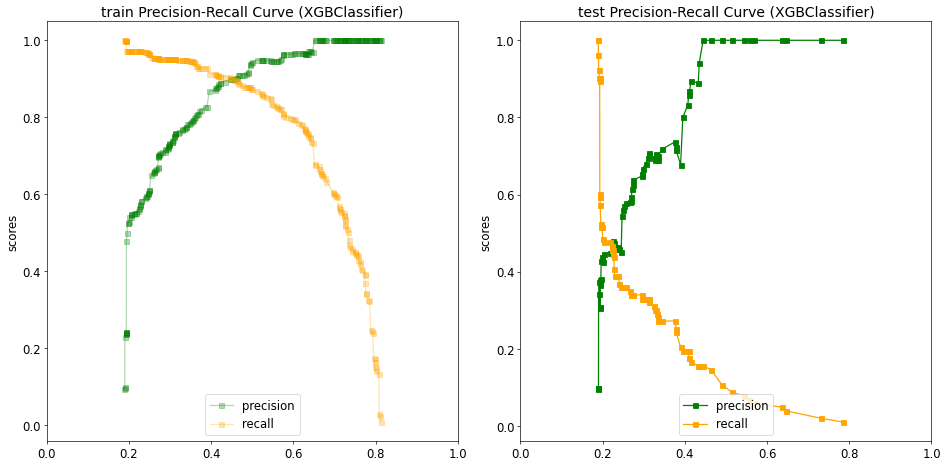


>>>>>>>>>>>>>>>>>>>>>>>>>> SVC model results <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


average precision of cross-validation:0.661


C:\Users\pucke\AppData\Local\Temp\ipykernel_2384\1464821687.py:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd_Series_importances = (pd.Series(importances, index=feature_names)).sort_values(ascending=False)


feature importance not available


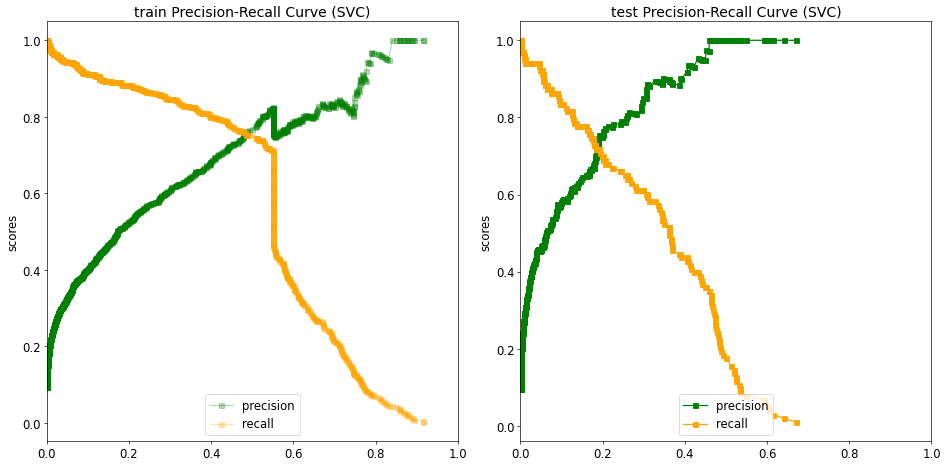

In [14]:
# use StandardScaler and Classification to build a classification pipeline.

classification_pipeline={}

for key,value in classification_models.items():

    classification_pipeline[key] = Pipeline([
        #('preprocessor',preprocessor),
        ('rescale', StandardScaler()),
        #('rescale', MinMaxScaler()),
        ('clf', value)
    ])
    
    print(f"\n\033[1m>>>>>>>>>>>>>>>>>>>>>>>>>> {key} model results <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\033[0m\n\n")
    
    train_scores = cross_val_score(classification_pipeline[key], X_train, y_train, scoring= 'average_precision', cv=5)
    print("average precision of cross-validation:{:.3f}".format(train_scores.mean()))
    
    classification_pipeline[key]=classification_pipeline[key].fit(X_train, y_train)
    
    # Use the predict function of the model to make predictions for the training set and test set,
    # and assign the outputs to y_train_pred and y_test_pred, respectively.

    y_train_pred = classification_pipeline[key].predict(X_train)
    y_test_pred = classification_pipeline[key].predict(X_test)
    
#--------------------------------------Feature Importance---------------------------------------------
    
    if key == 'RandomForest' or key == 'XGBClassifier':
        importances=classification_pipeline[key][1].feature_importances_
    elif key == 'LogisticRegression':
        importances=np.abs(classification_pipeline[key][1].coef_[0])
    else:
        try:
            importances=classification_pipeline[key][1].coef_
        except:
            importances=[]
    feature_names=classification_pipeline[key].feature_names_in_
    
    try:
        pd_Series_importances = (pd.Series(importances, index=feature_names)).sort_values(ascending=False)

        fig = plt.figure(figsize=(15,6))
        pd_Series_importances[:50].plot.bar()
        plt.title(f"Feature importances ({key})")
        plt.ylabel("importance")
        plt.xlabel("features")
        plt.show()
    except:
        print('feature importance not available')
    
#--------------------------------------Train PR---------------------------------------------
    y_train_proba=classification_pipeline[key].predict_proba(X_train)
    y_score = y_train_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_score)
    train_pr_df=pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})
    fig = plt.figure(figsize=(16,8),dpi=60)
    plt.subplot(1,2,1)
    plt.plot(train_pr_df.thresholds,train_pr_df.precision,'s-',color='green',label='precision',alpha=0.3)
    plt.plot(train_pr_df.thresholds,train_pr_df.recall,'s-',color='orange',label='recall',alpha=0.3)
    plt.legend(loc='lower center')
    plt.ylabel('scores')
    plt.xlim(0,1)
    plt.title(f'train Precision-Recall Curve ({key})')
        
#--------------------------------------Test PR---------------------------------------------
    y_test_proba=classification_pipeline[key].predict_proba(X_test)    
    y_score = y_test_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    test_pr_df=pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'thresholds':thresholds})
    plt.subplot(1,2,2)
    plt.plot(test_pr_df.thresholds,test_pr_df.precision,'s-',color='green',label='precision')
    plt.plot(test_pr_df.thresholds,test_pr_df.recall,'s-',color='orange',label='recall')
    plt.legend(loc='lower center')
    plt.ylabel('scores')
    plt.xlim(0,1)
    plt.title(f'test Precision-Recall Curve ({key})')
    
    plt.tight_layout()
    plt.show()

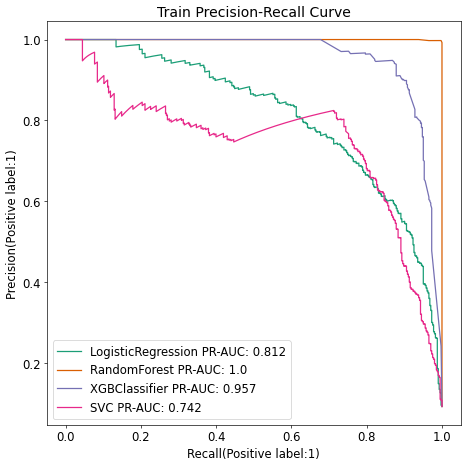

In [9]:
fig = plt.figure(figsize=(8,8),dpi=60)
colors = plt.cm.get_cmap("Dark2")
  
# Add line plots
i=0
for key in classification_pipeline.keys():
    y_train_proba=classification_pipeline[key].predict_proba(X_train) 
    y_score = y_train_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_score)
    auc_precision_recall = auc(recall, precision)
    
    plt.plot(recall, precision,color=colors(i), label=f'{key} PR-AUC: {round(auc_precision_recall,3)}' )
    i+=1
    
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title(f'Train Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

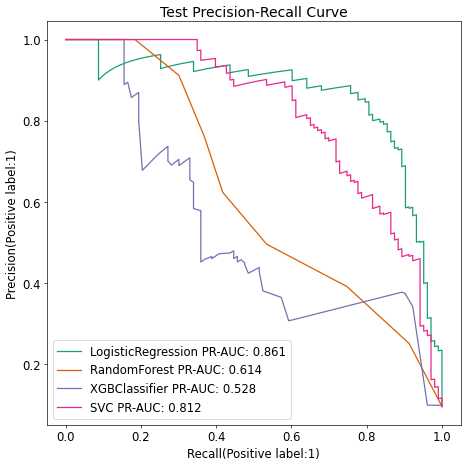

In [10]:
fig = plt.figure(figsize=(8,8),dpi=60)
colors = plt.cm.get_cmap("Dark2")
  
# Add line plots
i=0
for key in classification_pipeline.keys():
    y_test_proba=classification_pipeline[key].predict_proba(X_test) 
    y_score = y_test_proba[:, 1]

    # Data to plot precision - recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    auc_precision_recall = auc(recall, precision)
    
    plt.plot(recall, precision,color=colors(i), label=f'{key} PR-AUC: {round(auc_precision_recall,3)}' )
    i+=1
    
plt.xlabel('Recall(Positive label:1)')
plt.ylabel('Precision(Positive label:1)')
plt.title(f'Test Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

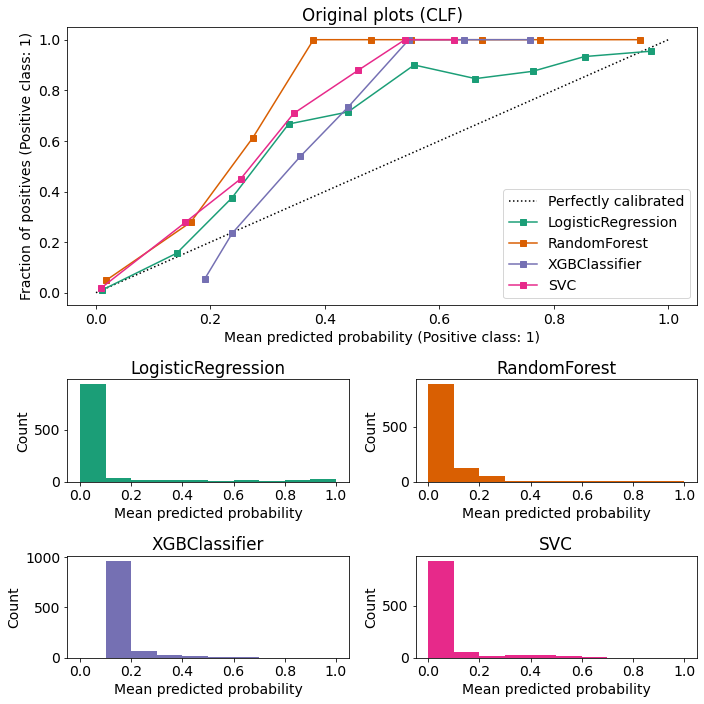

In [11]:
calibration_displays = {}

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
i=0
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
for key in classification_pipeline.keys():
    classification_pipeline[key].fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        classification_pipeline[key],
        X_test,
        y_test,
        n_bins=10,
        name=key,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[key] = display
    i+=1
ax_calibration_curve.set_title("Original plots (CLF)")
    
# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
i=0
for key in classification_pipeline.keys():
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        calibration_displays[key].y_prob,
        range=(0, 1),
        bins=10,
        label=key,
        color=colors(i),
    )
    ax.set(title=key, xlabel="Mean predicted probability", ylabel="Count")
    i+=1
    
plt.tight_layout()
plt.show()

## With CalibratedClassifierCV (isotonic)

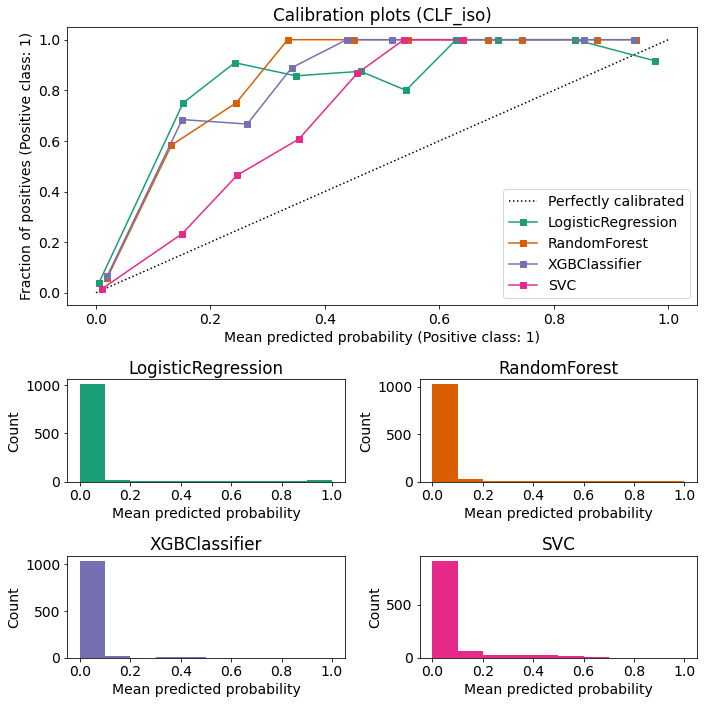

In [12]:
calibration_displays_iso = {}
clf_iso={}

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
i=0
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
for key in classification_pipeline.keys():
    clf_iso[key]=CalibratedClassifierCV(classification_pipeline[key], cv=5, method="sigmoid")
    clf_iso[key].fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf_iso[key],
        X_test,
        y_test,
        n_bins=10,
        name=key,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays_iso[key] = display
    i+=1
ax_calibration_curve.set_title("Calibration plots (CLF_iso)")
    
# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
i=0
for key in classification_pipeline.keys():
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        calibration_displays_iso[key].y_prob,
        range=(0, 1),
        bins=10,
        label=key,
        color=colors(i),
    )
    ax.set(title=key, xlabel="Mean predicted probability", ylabel="Count")
    i+=1
    
plt.tight_layout()
plt.show()

<hr>

## With CalibratedClassifierCV (sigmoid)

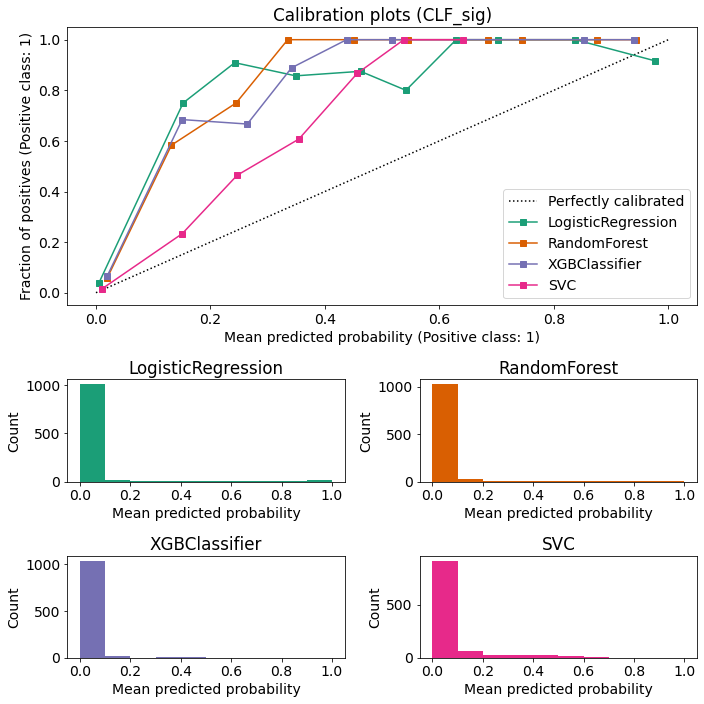

In [13]:
calibration_displays_sig = {}
clf_sig={}

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
i=0
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
for key in classification_pipeline.keys():
    clf_sig[key]=CalibratedClassifierCV(classification_pipeline[key], cv=5, method="sigmoid")
    clf_sig[key].fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf_sig[key],
        X_test,
        y_test,
        n_bins=10,
        name=key,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays_sig[key] = display
    i+=1
ax_calibration_curve.set_title("Calibration plots (CLF_sig)")
    
# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
i=0
for key in classification_pipeline.keys():
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        calibration_displays_sig[key].y_prob,
        range=(0, 1),
        bins=10,
        label=key,
        color=colors(i),
    )
    ax.set(title=key, xlabel="Mean predicted probability", ylabel="Count")
    i+=1
    
plt.tight_layout()
plt.show()